In [73]:
import os
import pickle
import time
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import collections
import pickle
import re
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [30]:
# uncomment if first time use
# !pip install mxnet-cu101 --target=$nb_path 

import mxnet as mx
from mxnet.gluon import nn, loss as gloss, rnn
from mxnet.gluon import data as gdata
from mxnet import gluon
from mxnet import nd,init
from mxnet.contrib import text
from mxnet import autograd

In [207]:
with open('./company_data.pickle', 'rb') as f:
    comp_data = pickle.load(f)
with open('./noun_verb_df.pickle', 'rb') as f:
    df = pickle.load(f)
df.head()

,text,target,filename,nouns,verbs
11922,Home - Coach aan Boord HomeCoachingstrajectenU...,16,595570,coach contact stuurman wal stuurman boord coac...,zijn moeten worden uitvoeren kunnen leren kunn...
4780,iMorang ICT SolutionsSterk in maatwerk softwar...,8,681629,solutionssterk maatwerk automatisering onderhoud,
13805,Enriching MomentsContact FormNameCompany nameC...,18,489353,enriching formnamecompany,
6822,Me&Maureen - Impact by Experience!Me and Maure...,9,459700,storie experiencecelebrating year heinekenom b...,
19156,info@allerleiklussen.nl 0521-589257 Toggle nav...,6,435558,overzichtschilderklussenklik overzichtallerlei...,navigationhomeallerleibuitenklussenschilderklu...


Calculate noun length and verb length, filter out those with total length than 30, we remove almost half of the data. Half of the data contains little information, perhaps due to scraping issues

In [208]:
df['noun_len'] = df['nouns'].apply(lambda x: len(x.split(" ")))
df['verb_len'] = df['verbs'].apply(lambda x: len(x.split(" ")))
df = df[df['noun_len'] + df['verb_len'] > 30]
out_dim = len(set(df['target']))

len(df), out_dim

(11090, 19)

In [25]:
n_train = 8000
df_train = df.iloc[:n_train]
df_test = df.iloc[n_train:]

In [209]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df = 15, sublinear_tf=True)
X_train = vectorizer.fit_transform(df_train['nouns'] + ' ' + df_train['verbs'])
Y_train = df_train['target']
X_test = vectorizer.transform(df_test['nouns'] + ' ' + df_test['verbs'])
Y_test = df_test['target']
X_train.shape, X_test.shape

((8000, 3428), (3090, 3428))

In [175]:
def LR(out_dim):
    net = nn.Sequential()
    net.add(nn.Dense(out_dim))
    net.initialize(init.Xavier())
    return net

def evaluate(net, iter):
    corr, n = 0, 0
    for batch in iter:
        X, y = batch
        out = net(X)
        corr += nd.sum(out.argmax(axis=1) == y.astype('float32')).asscalar() 
        n += y.size
    return corr/ n

def train(net, train_iter, test_iter, trainer, loss, num_epoch = 100, verbose=True):
    train_acc, test_acc = [evaluate(net, train_iter)], [evaluate(net, test_iter)]
    print("Before training, train acc: %.3f, test acc: %.3f"                   
          % (train_acc[-1], test_acc[-1]))
    for i in range(num_epoch):
        start = time.time()
        for batch in train_iter:
            X, y = batch
            with autograd.record():
                output = net(X)
                l_sum = loss(output, y)
            l_sum.backward()
            trainer.update(len(y))
        train_acc.append(evaluate(net, train_iter))
        test_acc.append(evaluate(net, test_iter))
        if verbose and (i+1)%5 == 0:
            print("epoch %d, train acc: %.3f, test acc: %.3f, time: %.3f" 
                  % (i+1, train_acc[-1], test_acc[-1], time.time() - start))
    plot_conv_line(train_acc, test_acc)
    return (train_acc, test_acc)

def plot_conv_line(train_acc, test_acc):
    x = np.arange(len(train_acc))
    plt.plot(x, train_acc, label='train_acc')
    plt.plot(x, test_acc, label='test_acc')
    plt.legend()
    plt.show()

In [176]:
batch_size = 128
train_set = gdata.ArrayDataset(nd.array(X_train.toarray()), nd.array(Y_train))
test_set = gdata.ArrayDataset(nd.array(X_test.toarray()), nd.array(Y_test))
train_iter = gdata.DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_iter = gdata.DataLoader(test_set, batch_size=batch_size)

Training the model

Before training, train acc: 0.044, test acc: 0.046
epoch 5, train acc: 0.826, test acc: 0.136, time: 0.593
epoch 10, train acc: 0.881, test acc: 0.131, time: 0.587
epoch 15, train acc: 0.898, test acc: 0.129, time: 0.574
epoch 20, train acc: 0.911, test acc: 0.131, time: 0.560
epoch 25, train acc: 0.910, test acc: 0.142, time: 0.507
epoch 30, train acc: 0.910, test acc: 0.138, time: 0.501


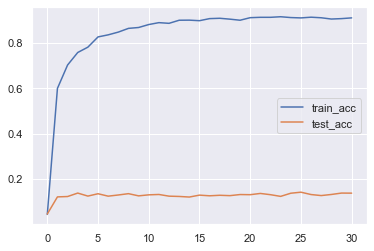

In [198]:
net = LR(out_dim)
loss = gloss.SoftmaxCrossEntropyLoss()
lr, wd, num_epoch = 1, 0, 30
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr, 'wd': wd})
train_acc, test_acc = train(net, train_iter, test_iter, trainer, loss, num_epoch)

See some concrete examples when models get wrong. Numbers are listed in top words and weight matrix is too large.

In [48]:
def print_top(label_names, top=10):
  top = nd.argsort(net[0].weight.data(), axis=1, is_ascend=False)[:, :top]
  top = top.asnumpy().astype('int32')
  names = [[vectorizer.get_feature_names()[idx] for idx in group] for group in top]
  for i, (words, label) in enumerate(zip(names, label_names)):
    print(f"{i}. {label.upper()}:\n {', '.join(words)}")
print_top(comp_data['target_names'])

0. LANDBOUW, BOSBOUW EN VISSERIJ:
 behoeve, aanvulling, projects, belasting, avanceren, gastvrijheid, opzetten, heer, werkzaamheid, effectiviteit
1. WINNING VAN DELFSTOFFEN:
 gezondheidscentrum, geleiden, discipline, foto, vertegenwoordigen, telefoonnummer, centrum, pand, bereiken, vestigen
2. INDUSTRIE:
 pakken, formule, peil, herkennen, everything, album, buis, searching, kids, paren
3. PRODUCTIE EN DISTRIBUTIE VAN EN HANDEL IN ELEKTRICITEIT, AARDGAS, STOOM EN GEKOELDE LUCHT:
 inkomen, particular, implementing, gemeente, welzijn, verkeer, geboorte, wind, werkzaamheid, after
4. WINNING EN DISTRIBUTIE VAN WATER; AFVAL- EN AFVALWATERBEHEER EN SANERING:
 toepassing, resultaat, mogen, project, bedrijf, transport, huis, uitzondering, bedrijfsonderdeel, garanderen
5. BOUWNIJVERHEID:
 airconditioning, what, inzetbaar, verduurzaming, vervoeren, gebeuren, stijging, printen, klantgerichtheid, bewegen
6. GROOT- EN DETAILHANDEL; REPARATIE VAN AUTO’S:
 acuut, fast, adviesdienst, openstaan, uitstek

Look into the weight, it is a little big

In [179]:
def get_top_weight(n=10):
    return nd.sort(net[0].weight.data(), axis=1, is_ascend=False)[:, :n]
    
print(get_top_weight(n=10))


[[ 55.276085   52.17853    47.27655    46.6514     44.00509    41.872044
   41.170956   40.6244     40.56773    40.244274 ]
 [ 11.589351    8.728068    7.221861    7.174574    7.169113    6.9574885
    6.955733    6.930854    6.864858    6.79882  ]
 [ 92.25338    74.61922    73.756096   73.636086   71.09224    64.940094
   64.23145    62.130898   61.46982    61.415848 ]
 [ 14.852799   13.906988   12.63293    12.57972    12.307718   11.665858
   11.159437   10.952002   10.687404    9.999612 ]
 [ 48.532402   33.12847    32.412273   32.38102    31.968296   31.925224
   31.746866   31.037268   30.647875   30.061958 ]
 [ 74.34743    70.07828    69.25027    66.06253    65.02627    62.23775
   61.961327   61.70715    61.293613   61.11616  ]
 [ 82.697876   78.318695   77.12284    76.03154    75.19879    73.418076
   73.26546    71.890144   69.86659    65.83695  ]
 [ 66.03033    62.99216    58.846085   54.206066   50.78222    50.71432
   50.03582    49.890854   49.443893   49.389874 ]
 [ 78.94

In [210]:
def predict(net, df, label_names):
    
    def to_label(yhats):
        return [label_names[i] for i in yhats.astype('int32').tolist()]
  

    X = vectorizer.transform(df['nouns'] + ' ' + df['verbs'])
    X = nd.array(X.toarray())
    out = net(X)
    yhats = out.argmax(axis = 1).asnumpy().astype('int32')
    df = pd.DataFrame({'filename': df['filename'], 'predict_label': to_label(yhats), 'predict': yhats, 'target_label': to_label(df['target']), 'target': df['target']})
    return df


predict(net, df.iloc[:10], comp_data['target_names'])

,filename,predict_label,predict,target_label,target
11922,595570,Gezondheids- en welzijnszorg,16,Gezondheids- en welzijnszorg,16
19156,435558,Groot- en detailhandel; reparatie van auto’s,6,Groot- en detailhandel; reparatie van auto’s,6
2459,610448,"Advisering, onderzoek en overige specialistisc...",12,Vervoer en opslag,7
9278,696999,"Cultuur, sport en recreatie",17,"Cultuur, sport en recreatie",17
14099,150734,Verhuur van en handel in onroerend goed,11,Verhuur van en handel in onroerend goed,11
2273,684030,Verhuur van roerende goederen en overige zakel...,13,Verhuur van roerende goederen en overige zakel...,13
4734,730534,Overige dienstverlening,18,Overige dienstverlening,18
12276,47776,"Cultuur, sport en recreatie",17,"Cultuur, sport en recreatie",17
9815,614639,Groot- en detailhandel; reparatie van auto’s,6,Groot- en detailhandel; reparatie van auto’s,6
10220,682517,"Advisering, onderzoek en overige specialistisc...",12,"Advisering, onderzoek en overige specialistisc...",12


In [211]:
predict(net, df_test.iloc[:10], comp_data['target_names'])

,filename,predict_label,predict,target_label,target
16317,553064,Financiële instellingen,10,Vervoer en opslag,7
798,605927,Informatie en communicatie,9,Financiële instellingen,10
17551,66753,Financiële instellingen,10,"Advisering, onderzoek en overige specialistisc...",12
16393,376236,Onderwijs,15,Financiële instellingen,10
15837,513720,"Cultuur, sport en recreatie",17,"Advisering, onderzoek en overige specialistisc...",12
14335,743719,"Advisering, onderzoek en overige specialistisc...",12,"Advisering, onderzoek en overige specialistisc...",12
4415,672071,"Advisering, onderzoek en overige specialistisc...",12,Groot- en detailhandel; reparatie van auto’s,6
13717,187591,Overige dienstverlening,18,"Advisering, onderzoek en overige specialistisc...",12
174,688816,Groot- en detailhandel; reparatie van auto’s,6,"Advisering, onderzoek en overige specialistisc...",12
5359,708821,Gezondheids- en welzijnszorg,16,Winning en distributie van water; afval- en af...,4


In [188]:
def get_confusion_matrix(y_true, y_predict, shape=20):
    arr = np.zeros(shape=(shape,shape), dtype='int32')
    for y, yhat in zip(y_true, y_predict):
        arr[y,yhat] += 1
    return arr

def plot_confusion_matrix(y_true, y_predict):
    confusion_matrix = get_confusion_matrix(y_true, y_predict, shape=20)
    plt.figure(figsize=(10,6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d')
    plt.show()

/Users/septem/opt/miniconda3/envs/da/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

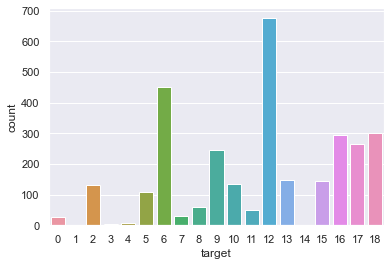

In [191]:
sns.countplot(df['target'])

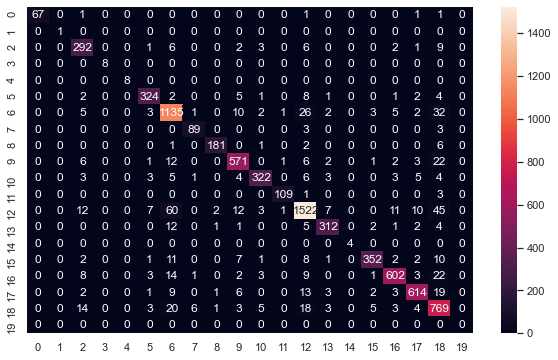

In [212]:
y_predict, y_true = predict(net, df_train, comp_data['target_names'])['predict'], df_train['target']
plot_confusion_matrix(y_true, y_predict)

In [213]:
sum(y_predict == y_true) / len(y_true)

0.91025

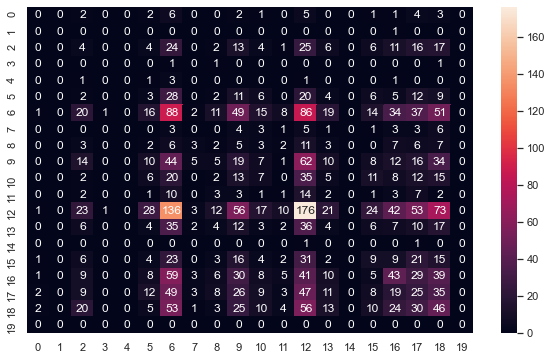

In [214]:
y_predict, y_true = predict(net, df_test, comp_data['target_names'])['predict'], df_test['target']
plot_confusion_matrix(y_true, y_predict)

In [216]:
sum(y_predict == y_true)/len(y_true)

0.13818770226537216

In [217]:
[target_names[idx] for idx in [6,9,12,16,17,18]]

['Groot- en detailhandel; reparatie van auto’s',
 'Informatie en communicatie',
 'Advisering, onderzoek en overige specialistische zakelijke dienstverlening',
 'Gezondheids- en welzijnszorg',
 'Cultuur, sport en recreatie',
 'Overige dienstverlening']

Before training, train acc: 0.051, test acc: 0.051
epoch 5, train acc: 0.210, test acc: 0.213, time: 0.657
epoch 10, train acc: 0.219, test acc: 0.217, time: 0.606
epoch 15, train acc: 0.191, test acc: 0.186, time: 0.527
epoch 20, train acc: 0.162, test acc: 0.154, time: 0.555
epoch 25, train acc: 0.185, test acc: 0.166, time: 0.536
epoch 30, train acc: 0.214, test acc: 0.215, time: 0.527


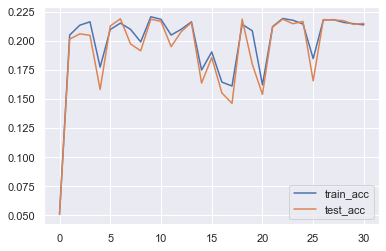

In [219]:
net_regularized = LR(out_dim)
loss = gloss.SoftmaxCrossEntropyLoss()
lr, wd, num_epoch = 1, 0.01, 30
trainer = gluon.Trainer(net_regularized.collect_params(), 'adam', {'learning_rate': lr, 'wd': wd})
train_acc, test_acc = train(net_regularized, train_iter, test_iter, trainer, loss, num_epoch)

This time weight is lot smaller, but little help to the problem

In [185]:
print(get_top_weight())


[[0.27609533 0.22369263 0.21536385 0.21477485 0.19761792 0.19663669
  0.18769094 0.18504399 0.1806344  0.17809235]
 [0.15498216 0.13866374 0.13285357 0.12616965 0.11285118 0.10906306
  0.10117013 0.09113605 0.08521757 0.07998712]
 [0.55569655 0.5329517  0.5135494  0.488437   0.48126417 0.46725324
  0.4626117  0.4524545  0.4483834  0.44808814]
 [0.15280059 0.13412344 0.1252639  0.12520802 0.12443191 0.12240298
  0.11836544 0.11605797 0.10836855 0.10830997]
 [0.19644845 0.19077456 0.18966128 0.18613626 0.18438847 0.18247172
  0.17441027 0.1689147  0.16564454 0.16308537]
 [0.5175635  0.507358   0.50505906 0.49352372 0.4921489  0.47677544
  0.43062934 0.42051443 0.38342732 0.37543643]
 [0.5353923  0.48948896 0.47186336 0.435708   0.43001017 0.42065662
  0.41650626 0.41059685 0.39767742 0.3929995 ]
 [0.29040322 0.28045303 0.2463687  0.22494861 0.21110031 0.20687011
  0.18448351 0.18429717 0.17876689 0.17685929]
 [0.608942   0.5464433  0.5441795  0.50166744 0.50089777 0.48114467
  0.4768621

Error on training data. As we can see, this just becomes a majority estimator, not what we want for the regularization

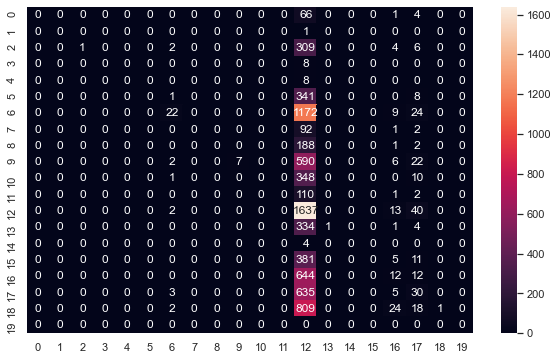

In [220]:
y_predict, y_true = predict(net_regularized, df_train, comp_data['target_names'])['predict'], df_train['target']
plot_confusion_matrix(y_true, y_predict)

Error on testing data

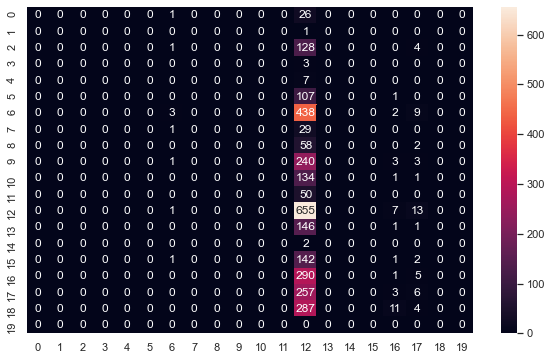

In [221]:
y_predict, y_true = predict(net_regularized, df_test, comp_data['target_names'])['predict'], df_test['target']
plot_confusion_matrix(y_true, y_predict)

Visualize the data

In [222]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [227]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X_train.toarray(), Y_train).transform(X_train.toarray())

In [278]:
def show_projection(X_r, cls = 20):
    figure = plt.figure()
    for i, target_name in zip(np.arange(0,cls), target_names):
        plt.scatter(X_r[Y_train == i, 0], X_r[Y_train == i, 1], alpha=.8,
                    label=target_name)

    # create a second figure for the legend
    legFigure = plt.figure()
    ax2 = legFigure.gca()

    legFigure.patch.set_visible(False)
    ax2.axis('off')
    # produce a legend for the objects in the other figure
    ax2.legend(*ax.get_legend_handles_labels())


PCA projection is not working

In [276]:
pca = PCA(n_components=2)
X_r = pca.fit(X_train.toarray()).transform(X_train.toarray())

In [281]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.01032431 0.00920521]


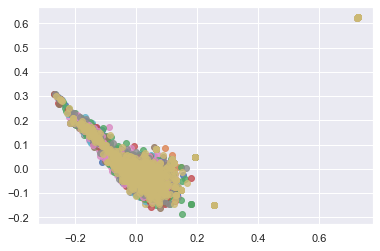

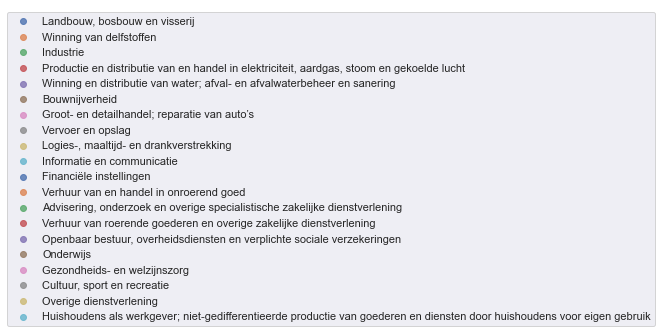

In [280]:
show_projection(X_r)

LDA projection, much better

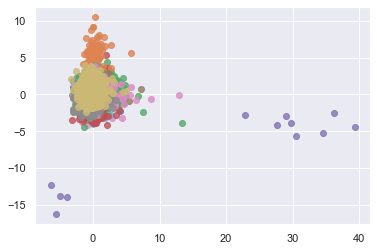

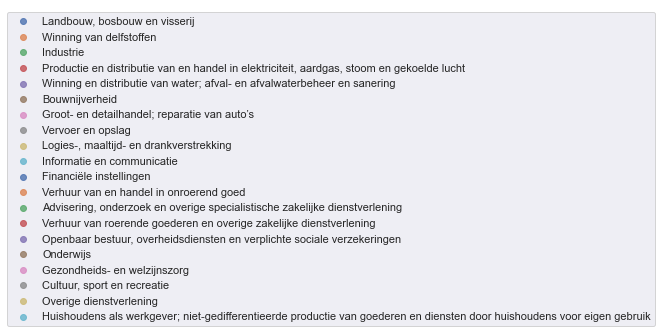

In [279]:
show_projection(X_r2)

List some easily confused categories according to the plot

In [283]:
[(i,name )for i,name in enumerate(target_names)]

[(0, 'Landbouw, bosbouw en visserij'),
 (1, 'Winning van delfstoffen'),
 (2, 'Industrie'),
 (3,
  'Productie en distributie van en handel in elektriciteit, aardgas, stoom en gekoelde lucht'),
 (4,
  'Winning en distributie van water; afval- en afvalwaterbeheer en sanering'),
 (5, 'Bouwnijverheid'),
 (6, 'Groot- en detailhandel; reparatie van auto’s'),
 (7, 'Vervoer en opslag'),
 (8, 'Logies-, maaltijd- en drankverstrekking'),
 (9, 'Informatie en communicatie'),
 (10, 'Financiële instellingen'),
 (11, 'Verhuur van en handel in onroerend goed'),
 (12,
  'Advisering, onderzoek en overige specialistische zakelijke dienstverlening'),
 (13, 'Verhuur van roerende goederen en overige zakelijke dienstverlening'),
 (14,
  'Openbaar bestuur, overheidsdiensten en verplichte sociale verzekeringen'),
 (15, 'Onderwijs'),
 (16, 'Gezondheids- en welzijnszorg'),
 (17, 'Cultuur, sport en recreatie'),
 (18, 'Overige dienstverlening'),
 (19,
  'Huishoudens als werkgever; niet-gedifferentieerde productie va

In [ ]:
target_names = comp_data['target_names']
f"Category {target_names[9]} is often confused with {', '.join(target_names[idx] for idx in [12, 13,15,16,17,18])}"

In [ ]:
df[df['target'].apply(lambda x: x in [9,12,13,18])]

In [170]:
from sklearn.linear_model import Perceptron

In [172]:
def measure(clf, X_train, y_train, X_test, y_test):
  t0 = time.time()
  clf.fit(X_train, y_train)
  train_time = time.time() - t0
  print("train time: %0.3fs" % train_time)

  t0 = time.time()
  pred = clf.predict(X_test)
  test_time = time.time() - t0
  print("test time:  %0.3fs" % test_time)

  score = metrics.accuracy_score(y_test, pred)
  print("accuracy:   %0.3f" % score)
measure(Perceptron(max_iter=50),X_train, df_train['target'], X_test, df_test['target'])

train time: 0.450s
test time:  0.005s
accuracy:   0.119


Tokenize the data

#########################################

In [ ]:
token_train = [doc.split() for doc in data_train.data]
token_test = [doc.split() for doc in data_test.data]
counter = collections.Counter(token for doc in token_train for token in doc)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


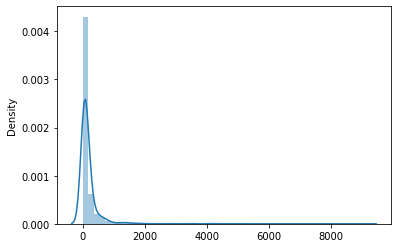

In [ ]:
vocab = text.vocab.Vocabulary(counter, unknown_token='<unknown>', reserved_tokens=['<pad>'])
sns.distplot([len(doc) for doc in  token_train])

In [ ]:
df = pd.DataFrame([len(doc) for doc in  token_train])
df.describe()

,0
count,2034.000000
mean,191.523107
std,541.931348
min,0.000000
25%,38.000000
50%,76.000000
75%,154.000000
max,9109.000000


In [ ]:
# TODO: contains 0 length doc!

In [ ]:
def pad(x, max_l):
    return x[:max_l] if len(x) > max_l else x + [
        vocab.token_to_idx['<pad>']] * (max_l - len(x))

def token2idx(tokens, vocab): 
    indices = []
    max_l = 300   # this is estimated by data distribution
    for doc in tokens:
       indices.append(pad(vocab.to_indices(doc), max_l))
    return indices

X_train = token2idx(token_train, vocab)

X_test = token2idx(token_test, vocab)

In [ ]:
len(token_train), len(token_test)

(2034, 1353)

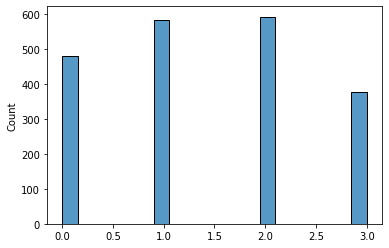

In [ ]:
sns.histplot(data_train.target)

In [ ]:
batch_size = 32

train_set = gdata.ArrayDataset(X_train,data_train.target.tolist())
test_set = gdata.ArrayDataset(X_test, data_test.target.tolist())
train_iter = gdata.DataLoader(train_set, batch_size, shuffle=True)
test_iter = gdata.DataLoader(test_set, batch_size)

In [ ]:
class RNN(nn.Block):
    def __init__(self, vocab, embed_size, num_hiddens, num_layers, output_dim, **kwargs):
        super(RNN, self).__init__(**kwargs)
        
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                input_size=embed_size, dropout=0.5)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Dense(output_dim)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        # outputs = self.encoder(nd.one_hot(inputs.T, len(vocab)))
        outputs = self.encoder(embeddings)
        outs = self.decoder(outputs[-1])
        return self.dropout(outs)

In [ ]:
text.embedding.get_pretrained_file_names('glove')

['glove.42B.300d.txt',
 'glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt',
 'glove.840B.300d.txt',
 'glove.twitter.27B.25d.txt',
 'glove.twitter.27B.50d.txt',
 'glove.twitter.27B.100d.txt',
 'glove.twitter.27B.200d.txt']

In [ ]:
glove_embedding = text.embedding.create(
    'glove', pretrained_file_name='glove.6B.100d.txt', vocabulary=vocab)

In [ ]:
glove_embedding.idx_to_token[:10]

['<unknown>', '<pad>', 'the', 'to', 'of', 'a', 'and', 'is', 'in', 'I']

In [ ]:
def evaluate_accuracy(net, iter, ctx):
  acc_sum = 0
  n = 0
  for i, batch in enumerate(iter):
    X,y = [d.as_in_context(ctx) for d in batch]
    y_hats = net(X)
    acc_sum += (y_hats.argmax(axis=1) == y.astype('float32')).sum().asscalar()
    n += y.size
  # print(acc_sum, n)
  return acc_sum / n

def train(train_iter, test_iter, net, loss, trainer_weight, trainer_bias, ctx, num_epochs):
    """Train and evaluate a model."""
    print('training on', ctx)
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            X,y = [d.as_in_context(ctx) for d in batch]
            with autograd.record():
                y_hats = net(X)
                ls = loss(y_hats, y)
                ls.backward()
            trainer_weight.step(batch_size)
            trainer_bias.step(batch_size)
            train_l_sum += ls.sum().asscalar()
            n += ls.size
            # train_acc_sum += (y_hats.argmax(axis=1) == y.astype('float32')).sum().asscalar()
            # m += y.size
        # if (epoch+1) % 5 == 0:
        train_acc = evaluate_accuracy(net, train_iter, ctx)
        test_acc = evaluate_accuracy(net, test_iter, ctx)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc, test_acc,
                time.time() - start))

In [ ]:
for x,y in train_iter:
  print(x.shape)
  break

(32, 300)


In [ ]:
def get_net():
  embed_size, num_hiddens, num_layers, output_dim, ctx = 100, 20, 1, 4, mx.gpu()
  net = RNN(vocab, embed_size, num_hiddens, num_layers, output_dim)
  net.initialize(init.Xavier(), ctx=ctx, force_reinit=True)
  net.embedding.weight.set_data(glove_embedding.idx_to_vec)
  net.embedding.collect_params().setattr('grad_req', 'null')
  return net


In [ ]:
net = get_net()
ctx = mx.gpu()
evaluate_accuracy(net, train_iter, ctx)

0.14700098328416913

In [ ]:
lr, num_epochs, wd = 0.1, 10, 0
weight_trainer = gluon.Trainer(net.collect_params('.*weight'), 'adam', {'learning_rate': lr, 'wd': wd})
bias_trainer = gluon.Trainer(net.collect_params('.*bias'), 'adam', {'learning_rate': lr})
loss = gloss.SoftmaxCrossEntropyLoss()
train(train_iter, test_iter, net, loss, weight_trainer, bias_trainer, ctx, num_epochs)

training on gpu(0)
epoch 1, loss 2.2378, train acc 0.306, test acc 0.291, time 4.5 sec
epoch 2, loss 2.1533, train acc 0.295, test acc 0.293, time 4.4 sec
epoch 3, loss 2.1250, train acc 0.306, test acc 0.295, time 4.4 sec
epoch 4, loss 2.1687, train acc 0.301, test acc 0.292, time 4.4 sec
epoch 5, loss 2.1525, train acc 0.324, test acc 0.293, time 4.4 sec
epoch 6, loss 2.1768, train acc 0.319, test acc 0.285, time 4.4 sec
epoch 7, loss 2.1512, train acc 0.296, test acc 0.295, time 4.4 sec
epoch 8, loss 2.1926, train acc 0.304, test acc 0.302, time 4.4 sec
epoch 9, loss 2.1795, train acc 0.324, test acc 0.296, time 4.4 sec
epoch 10, loss 2.1467, train acc 0.300, test acc 0.290, time 4.4 sec
